In [1]:
# USAGE
# python train_mask_detector.py --dataset dataset

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
#!pip install matplotlib

In [3]:
#!pip install imutils

In [4]:
#!pip install opencv-python-headless

In [5]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [6]:
#!pip install scikit-learn

In [7]:
# r before string will prevent Python from interpreting escape characters.
DIRECTORY = r"C:\Deep learning\Face Mask Detection\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [8]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = [] 

[INFO] loading images...


In [9]:
from imutils import paths

# Define the path to your dataset
dataset_path = r"C:\Deep learning\Face Mask Detection\dataset"

# List all image paths in the dataset
imagePaths = list(paths.list_images(dataset_path))

# Print the number of images found and a few example paths
print(f"Found {len(imagePaths)} images.")
print("Example image paths:")
print(imagePaths[:5])  # Print first 5 image paths

Found 3846 images.
Example image paths:
['C:\\Deep learning\\Face Mask Detection\\dataset\\without_mask\\0.jpg', 'C:\\Deep learning\\Face Mask Detection\\dataset\\without_mask\\0_0_aidai_0014.jpg', 'C:\\Deep learning\\Face Mask Detection\\dataset\\without_mask\\0_0_aidai_0029.jpg', 'C:\\Deep learning\\Face Mask Detection\\dataset\\without_mask\\0_0_aidai_0043.jpg', 'C:\\Deep learning\\Face Mask Detection\\dataset\\without_mask\\0_0_aidai_0074.jpg']


In [10]:
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

C:\Users\yuga\anaconda3\envs\aiml\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [11]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


In [12]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [14]:
# Construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [15]:
# Construct the validation image generator
val_aug = ImageDataGenerator()

In [16]:
# Create data generators
train_generator = aug.flow(trainX, trainY, batch_size=BS)
val_generator = val_aug.flow(testX, testY, batch_size=BS)

In [17]:
train_generator 

In [18]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9406464/9406464 [==============================] - 55s 6us/step


In [19]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [20]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [21]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [22]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [23]:
# Compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [24]:
# Train the head of the network
print("[INFO] training head...")
H = model.fit(
    train_generator,
    steps_per_epoch=len(trainX) // BS,
    validation_data=val_generator,
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/10
96/96 [==============================] - 388s 4s/step - loss: 0.3747 - accuracy: 0.8706 - val_loss: 0.1451 - val_accuracy: 0.9857
Epoch 2/10
96/96 [==============================] - 293s 3s/step - loss: 0.1543 - accuracy: 0.9570 - val_loss: 0.0847 - val_accuracy: 0.9857
Epoch 3/10
96/96 [==============================] - 323s 3s/step - loss: 0.0990 - accuracy: 0.9740 - val_loss: 0.0661 - val_accuracy: 0.9883
Epoch 4/10
96/96 [==============================] - 297s 3s/step - loss: 0.0846 - accuracy: 0.9757 - val_loss: 0.0538 - val_accuracy: 0.9909
Epoch 5/10
96/96 [==============================] - 306s 3s/step - loss: 0.0667 - accuracy: 0.9803 - val_loss: 0.0465 - val_accuracy: 0.9896
Epoch 6/10
96/96 [==============================] - 273s 3s/step - loss: 0.0594 - accuracy: 0.9829 - val_loss: 0.0437 - val_accuracy: 0.9909
Epoch 7/10
96/96 [==============================] - 284s 3s/step - loss: 0.0569 - accuracy: 0.9826 - val_loss: 0.0415 - val_accura

In [25]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
25/25 [==============================] - 59s 2s/step


In [26]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [27]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       384
without_mask       0.99      0.99      0.99       386

    accuracy                           0.99       770
   macro avg       0.99      0.99      0.99       770
weighted avg       0.99      0.99      0.99       770



In [28]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("Face_Mask_Detector.h5")


[INFO] saving mask detector model...


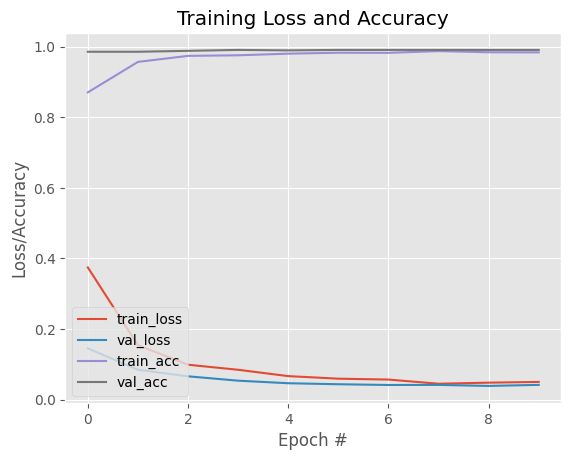

In [29]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")